In [1]:
###################################################################
# Built-in modules ################################################
###################################################################
import sys
import os

sys.path.append("../../")

import numpy as np
import imp
import cv2
import os
import matplotlib.pyplot as plt
import gc

import math
import time
import glob

###################################################################
# Custom modules ##################################################
###################################################################

from components.matchers.NumbaPatchMatcher import Wrapper as m
from components.utils.SimpleProgressBar import SimpleProgressBar
from components.utils import utils as u
from components.utils import plot_utils as plu
from components.utils.CSVWriter2 import Wrapper as csv
from components.utils.Metrix import Wrapper as me

###################################################################
# Dataset specific modules#########################################
###################################################################

from components.utils import middlebury_utils as mbu


In [2]:
ROOT_PATH = os.path.join("..", "..")
EXPERIMENT_TITLE = "ALG_005_EXP_009-PatchMatch-MacLean_et_al-Numba_H"

INIT_METHOD = "maclean"
DATASET = "middlebury"

DATASET_FOLDER = os.path.join(ROOT_PATH, "datasets", DATASET)
LOG_FOLDER = os.path.join(ROOT_PATH, "experiments", "logs")
CSV_FILEPATH = os.path.join(LOG_FOLDER, EXPERIMENT_TITLE+".csv")
IMG_RES = "450X375"
PREPROCESSING_METHOD = "None"
KERNEL_SIZE = 1
KERNEL_SPEC = "None"

SCENES = ["teddy", "cones"]
SIZE="H"
YEAR= 2003
EXP_PARAMS = dict()

#  Loading the dataset and visualising the results

..\..\datasets\middlebury\middlebury_2003\teddyH
..\..\datasets\middlebury\middlebury_2003\teddyH\im2.ppm
..\..\datasets\middlebury\middlebury_2003\teddyH\im6.ppm
..\..\datasets\middlebury\middlebury_2003\teddyH\disp2.pgm
..\..\datasets\middlebury\middlebury_2003\teddyH\nonocc.png
..\..\datasets\middlebury\middlebury_2003\conesH
..\..\datasets\middlebury\middlebury_2003\conesH\im2.ppm
..\..\datasets\middlebury\middlebury_2003\conesH\im6.ppm
..\..\datasets\middlebury\middlebury_2003\conesH\disp2.pgm
..\..\datasets\middlebury\middlebury_2003\conesH\nonocc.png


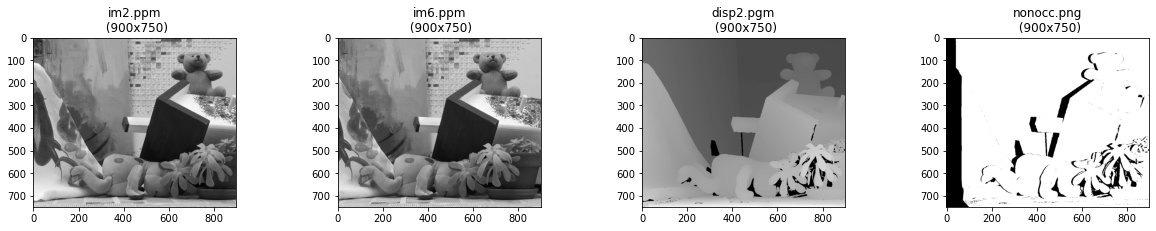

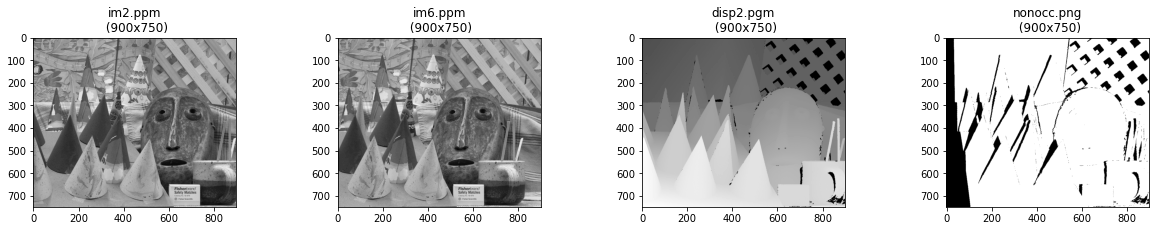

In [3]:
loaded_imgs_and_paths = list(mbu.get_images(DATASET_FOLDER, YEAR, scene, size = SIZE) for scene in SCENES)

for im, path in loaded_imgs_and_paths:
    filenames = list(os.path.split(p)[-1] for p in path)
    plu.plot_images(im, filenames)

# Benchmarking and evaluation

In [4]:
###################################################################
# Initialising hyperparameters and matcher#####################
###################################################################

csv_logger = csv(CSV_FILEPATH, default_header=False)
csv_logger.set_header_function(csv_logger.get_header_v3)
csv_logger.write_csv_header()
csv_logger.set_line_function(csv.format_stereo_matching_results_v2)

MATCH = 30
GAP = -20
EGAP = -1


EXP_PARAMS = {"experiment_id":EXPERIMENT_TITLE, "match": MATCH,"gap":GAP,"egap":EGAP,\
                  "algo":str(m.__module__), "init_method":"default","dataset":DATASET,\
                  "preprocessing_method":"None","kernel_size":1,"kernel_spec":"None"}

File ..\..\experiments\logs\ALG_005_EXP_009-PatchMatch-MacLean_et_al-Numba_H.csv already exists, header has not been written.


In [5]:
###################################################################
# Matching ####################################################
###################################################################

results = []

EXP_PARAMS["init_method"] = "maclean_et_al"

patches = [np.ones((5,3)),
           np.ones((7,3)), 
           np.ones((7,5)),
           np.ones((9,3)), 
           np.ones((11,3)),
           np.ones((13,3)),
           np.ones((15,3))
          ]

matcher = m(MATCH, GAP, EGAP)
progress_bar = SimpleProgressBar.get_instance()

progress_counter = 1
steps_to_be_taken = len(SCENES)*len(patches)*5


SAVE_PATH  = os.path.join(ROOT_PATH, "experiments", "disparities", EXPERIMENT_TITLE)

saved_image_names = []
results = []

In [6]:
for match_value in range(20,60, 10):
    for p in patches:
        for i, scene in enumerate(SCENES):
            EXP_PARAMS["match"] = MATCH = match_value
            matcher = m(MATCH, GAP, EGAP)
            
            EXP_PARAMS["scene"] = scene
            EXP_PARAMS["image_filename"] = IMAGE_FILENAME = loaded_imgs_and_paths[i][1][0]
            EXP_PARAMS["img_res"] = "{0}x{1}".format(loaded_imgs_and_paths[i][0][1].shape[1], loaded_imgs_and_paths[i][0][1].shape[0])  
            EXP_PARAMS["kernel_size"] = "{0}x{1}".format(p.shape[0], p.shape[1])

            occ = loaded_imgs_and_paths[i][0][3]
            gt = loaded_imgs_and_paths[i][0][2]

            matcher.set_images(loaded_imgs_and_paths[i][0][0].astype(np.float64), loaded_imgs_and_paths[i][0][1].astype(np.float64))
            tic = time.time()

            matcher.configure_instance(passed_dmax=128)
            matcher.set_filter(p)

            tic=time.time()

            x,raw_disp_map = matcher.test_pipeline()
            toc = time.time()

            EXP_PARAMS["runtime"] = toc-tic

            disp = raw_disp_map
            disp = 2*disp
            
            temp_path = u.save_disparity(SAVE_PATH, disp)
            saved_image_names.append(os.path.split(temp_path)[-1])
        
            EXP_PARAMS["image_filename"] = temp_path

            EXP_PARAMS["are_occlusions_errors"] = ARE_OCCLUSIONS_ERRORS = False

            EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["BAD8"], EXP_PARAMS["abs_error"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
            BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, occ, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

            csv_logger.append_new_sm_results(EXP_PARAMS, selected_keys=csv.get_header_v3())

            EXP_PARAMS["are_occlusions_errors"]  = True
            EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["BAD8"], EXP_PARAMS["abs_error"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
            BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, gt, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

            csv_logger.append_new_sm_results(EXP_PARAMS, selected_keys=csv.get_header_v3())
            results.append(disp)

            progress_bar.progress_bar(progress_counter, steps_to_be_taken, header= "Experiment on patch sizes in progress: ", progress_bar_steps=40)
            progress_counter+=1

Experiment on patch sizes in progress:  [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>--------] 80.00 % completed: 56 / 70 steps

In [7]:
import pandas as pd
experiment_log = pd.read_csv(CSV_FILEPATH)
experiment_log.sort_values(by="bad4", inplace=True) 
experiment_log.head(30)

,experiment_id,match,gap,egap,algo,init_method,dataset,scene,image_filename,img_res,...,are_occlusions_errors,abs_error,mse,avg,eucledian,bad1,bad2,bad4,bad8,runtime
22,ALG_005_EXP_009-PatchMatch-MacLean_et_al-Numba_H,20,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_009-...,900x750,...,False,3749668.0,713.882772,6.533991,20240.469856,0.248213,0.143145,0.102621,0.071589,279.544145
14,ALG_005_EXP_009-PatchMatch-MacLean_et_al-Numba_H,20,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_009-...,900x750,...,False,3723776.0,706.196584,6.488873,20131.213078,0.249560,0.143461,0.102746,0.071295,256.803415
6,ALG_005_EXP_009-PatchMatch-MacLean_et_al-Numba_H,20,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_009-...,900x750,...,False,3746278.0,709.675526,6.528084,20180.738440,0.252370,0.144841,0.102828,0.071694,261.810064
18,ALG_005_EXP_009-PatchMatch-MacLean_et_al-Numba_H,20,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_009-...,900x750,...,False,3732642.0,710.157774,6.504322,20187.594012,0.249234,0.143438,0.102852,0.071042,262.833569
26,ALG_005_EXP_009-PatchMatch-MacLean_et_al-Numba_H,20,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_009-...,900x750,...,False,3778500.0,715.378299,6.584232,20261.659853,0.249295,0.145512,0.105135,0.072863,275.725311
2,ALG_005_EXP_009-PatchMatch-MacLean_et_al-Numba_H,20,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_009-...,900x750,...,False,3825260.0,722.992582,6.665714,20369.204108,0.259414,0.149541,0.105259,0.073846,264.209152
10,ALG_005_EXP_009-PatchMatch-MacLean_et_al-Numba_H,20,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_009-...,900x750,...,False,3892330.0,737.840016,6.782587,20577.293019,0.255582,0.148124,0.106226,0.074850,278.027651
42,ALG_005_EXP_009-PatchMatch-MacLean_et_al-Numba_H,30,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_009-...,900x750,...,False,3707290.0,668.615170,6.460145,19588.232590,0.259574,0.153144,0.110110,0.076796,297.878555
50,ALG_005_EXP_009-PatchMatch-MacLean_et_al-Numba_H,30,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_009-...,900x750,...,False,3707710.0,669.352583,6.460877,19599.031507,0.259496,0.153651,0.110171,0.076515,283.774868
46,ALG_005_EXP_009-PatchMatch-MacLean_et_al-Numba_H,30,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_009-...,900x750,...,False,3690014.0,666.049325,6.430041,19550.611039,0.260477,0.153507,0.110330,0.075888,313.751439
